## **Advanced Lane Finding Project**

### The goals / steps of this project are the following:

---


* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Project Writeup by Albert Vo
---
Once you have completed the code implementation, document your results in a project writeup using this template as a guide. The writeup can be in a markdown or pdf file. 

This P4 Advanced Lane Finding Notebook represents my project code and also my project writeup. 
References and Attributions:
1.  Albert Vo Code and Writeup 
2.  Udacity Course Material
3.  Jessica Yung Github
4.  Jeremy Shannon Github

In [1]:
# Imports
import numpy as np
import cv2
import pickle
import glob
import supportfunct
from supportfunct import *

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline




### Camera Calibration

1.  Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Answer:


#### 1. First I computed the camera matrix and distortion coefficients.  I provide an example of a distortion corrected calibration image.


[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video_output.mp4 "Video"
 

I used OpenCV functions to calculate the correct camera matrix and distortion coefficients using the 9x6 calibration chessboard images provided in the repository. I used a distortion matrix to un-distort the example  calibration images to show that the calibration is correct. 

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 



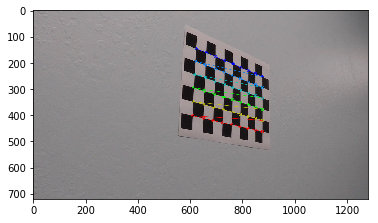

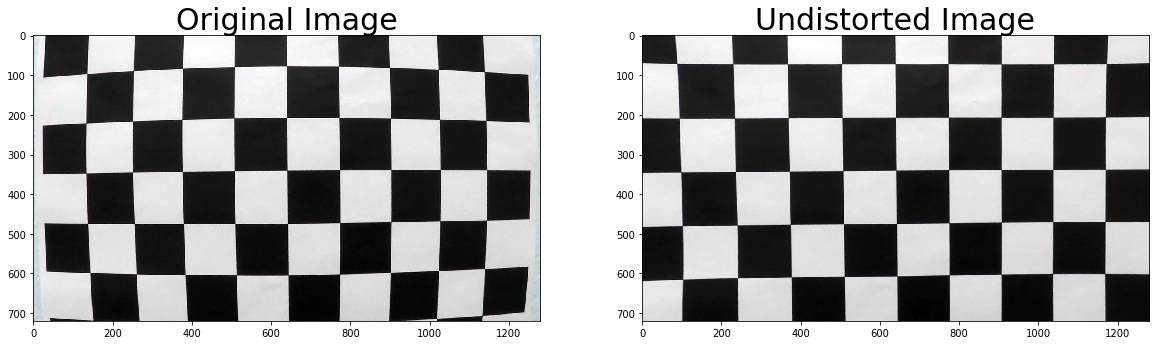

In [2]:
# Pipeline Stage 1:  Distortion Corrected Image
# 1.  Read in Calibration Images
# 2.  Find Chessboard Corners to calibrate
# 2.  Read in Distorted Image
# 3.  Undistort Distorted Image

# Object Points
nx = 9 
ny = 6 

images = glob.glob("camera_cal/calibration*.jpg")

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

for fname in images:

    img = cv2.imread(fname)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline (single images)
[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

#### 1. Provide an example of a distortion-corrected image.


Answer:

I performed distortion correction by using the camera calibration and applying OpenCV undistort to each image. 

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
print('...')![alt text][image2]


In [3]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]


True

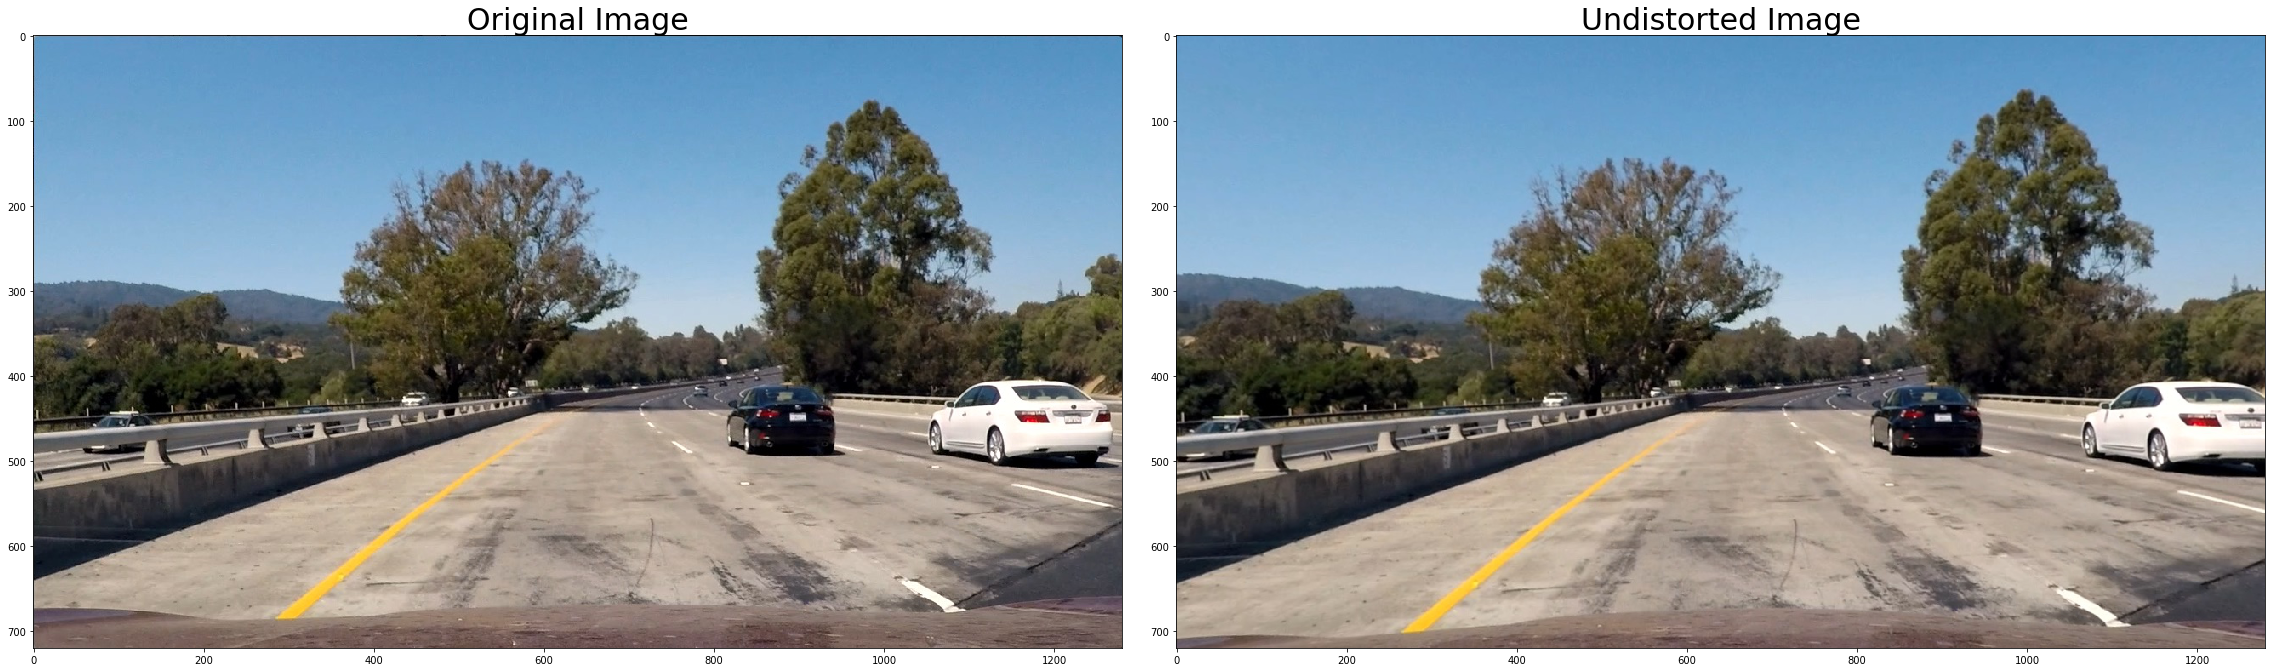

In [4]:
# undistort image using pickled camera calibration matrix
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Chose test image test1.jpg
Img = cv2.imread('./test_images/test1.jpg')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
#plt.imshow(Img)

Img_size = (Img.shape[1], Img.shape[0])
Img_undistort = undistort(Img)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(Img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(Img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, Img_size,None,None)

dst = cv2.undistort(Img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)
cv2.imwrite('test1_undistorted.jpg',dst)

### Pipeline (single images)

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"


#### 2. Describe how you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

Answer:

I used a combination of color transform and gradient thresholds to generate a binary image (thresholding).  

I created a binary image containing likely lane pixels by combining the output results of color transforms and gradients. I use visual verification to confirm that the pixels identified as part of the lane lines are correct. 

In [5]:
def set_sobel_parameters(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    # Threshold color channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

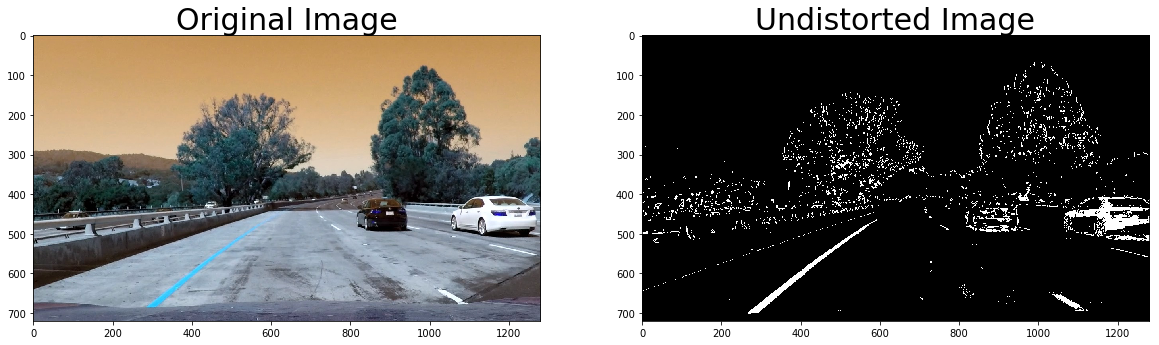

In [6]:
# Undistort Image
raw = cv2.imread("test_images/test1.jpg")
image = cv2.undistort(raw, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)


imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

combined_binary = set_sobel_parameters(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

### Pipeline (single images)

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"



#### 3. Describe how you performed a perspective transform and provide an example of a transformed image.


Answer:

I used OpenCV functions findChessboardCorners, drawChessboardCorners and unwarp to correct distortion and transform each image to a "birds-eye view". 

The code for my perspective transform includes a function called unwarp().  The `unwarp()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```python
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]


In [7]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M

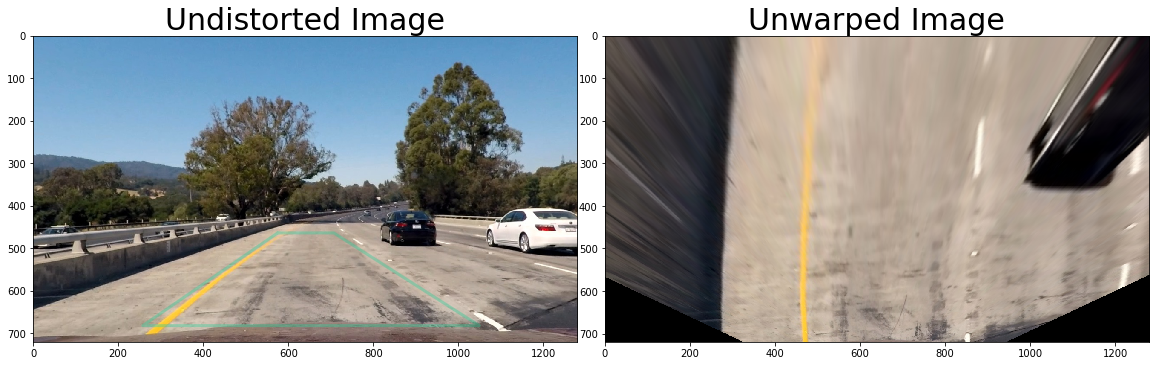

In [8]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


h,w = Img_undistort.shape[:2]

src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

Img_unwarp, M, Minv = unwarp(Img_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(Img_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(Img_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)


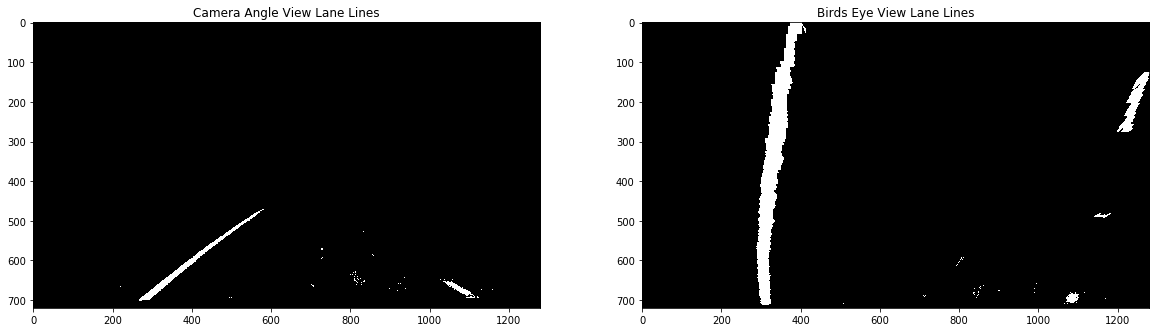

In [9]:
## 3. Transform perspective into a "birds-eye view").

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)

###################  Transform Perspective into Bird's Eye View
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp onto birds-eye-view
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
#plt.subplot(1,2,1, figsize=(20,10))
#plt.figure(figsize=(20,10))
plt.title('Camera Angle View Lane Lines')
plt.imshow(masked_image, cmap="gray")


plt.subplot(1,2,2)
#plt.figure(figsize=(20,10))
plt.title('Birds Eye View Lane Lines')
plt.imshow(warped, cmap="gray")



### Pipeline (single images)

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video_output.mp4 "Video"



#### 4.  Here I identified lane-line pixels and fit their positions with a 2nd order polynomial
![alt text][image5]


Answer:

I used a binary thresholded image to identify lane line pixels. I identified the left and right line and fitted them with a curved functional form, a second order polynomial.  Then, I plotted out the original images and overlayed the line pixels identified as lane lines on top.


#1.  Locate the Lane Lines and Fit a Polynomial

After I thresholded warped image, I mapped out the lane lines! 

Line Finding Method: Peaks in a Histogram

After applying calibration, thresholding, and a perspective transform to a road image, I have a binary image where the lane lines stand out clearly. Next, I identified which pixels are part of the lines and which belong to the left line and which belong to the right line.  Then I took a histogram along all the columns in the lower half of the image.


#2.  Sliding Window

I used the histogram and I added up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1.

The lane lines are represented by two most prominent peaks in this histogram. 


I used the two peaks to search for the lines. Then, I used a sliding window, placed around the line centers, to find and follow the lines.

#3.  Implement Sliding Windows and Fit a Polynomial

Next I used a warped binary image called binary_warped and I found which "hot" pixels are associated with the lane lines. 


#4.  Visualization

After I found the Lane, then I visualized the results.


#5.  Skip the sliding windows step once I know where the lines are

After I found the lane lines, I do not need to do a blind search again in the video frame.  Instead, I searched in a margin around the previous line position.

#6.  I have highlighted the steps taken to identify the lane lines.
The green shaded area shows where I searched for the lines. I used a sliding window and search within region of interest for each frame of video.  By keeping track of previous windows, I can track the lanes through sharp curves and poor lighting conditions where you can lose track of the lines.





In [10]:
from scipy import signal

def fit_2nd_order_poly(indep, dep, return_coeffs=False):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit
    else:
        return fitdep

def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

def get_pixels(img, x_center, y_center, size):
    half_size = size // 2
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y


def aggregate_arrays(leftx, lefty, rightx, righty):
    leftx = [x
             for array in leftx
             for x in array]
    lefty = [x
             for array in lefty
             for x in array]
    rightx = [x
              for array in rightx
              for x in array]
    righty = [x
              for array in righty
              for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty

def get_pixels_histogram(warped_thresholded_image, offset=50, steps=6,
                     window_radius=200, medianfilt_kernel_size=51,
                     horizontal_offset=50):

    left_x = []
    left_y = []
    right_x = []
    right_y = []

    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    width = warped_thresholded_image.shape[1]
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps

    for step in range(steps):
        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

 
        window_start_y = height - (step * pixels_per_step) + offset
        window_end_y = window_start_y - pixels_per_step + offset

        histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y), int(horizontal_offset):int(width - horizontal_offset)], axis=0)
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixels(warped_thresholded_image, left_x_centre,
                                                                       y_centre, window_radius)
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixels(warped_thresholded_image, right_x_centre,
                                                                         y_centre, window_radius)
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)

    if len(right_x) == 0 or len(left_x) == 0:
        print("Init no peaks for left or right")
        print("left_x: ", left_x)
        print("right_x: ", right_x)

        horizontal_offset = 0

        left_x = []
        left_y = []
        right_x = []
        right_y = []

        for step in range(steps):
            left_x_window_centres = []
            right_x_window_centres = []
            y_window_centres = []

            window_start_y = height - (step * pixels_per_step) + offset
            window_end_y = window_start_y - pixels_per_step + offset

            histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y),
                               int(horizontal_offset):int(width - horizontal_offset)], axis=0)
            histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

            left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
            right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
            if len(left_peaks) > 0:
                left_peak = max(left_peaks)
                left_x_window_centres.append(left_peak)

            if len(right_peaks) > 0:
                right_peak = max(right_peaks) + half_frame
                right_x_window_centres.append(right_peak)

            if len(left_peaks) > 0 or len(right_peaks) > 0:
                y_window_centres.append((window_start_y + window_end_y) // 2)

            for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
                left_x_additional, left_y_additional = get_pixels(warped_thresholded_image, left_x_centre,
                                                                           y_centre, window_radius)
                left_x.append(left_x_additional)
                left_y.append(left_y_additional)

            for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
                right_x_additional, right_y_additional = get_pixels(warped_thresholded_image, right_x_centre,
                                                                             y_centre, window_radius)
                right_x.append(right_x_additional)
                right_y.append(right_y_additional)

    return aggregate_arrays(left_x, left_y, right_x, right_y)

def lane_poly(yval, poly_coeffs):
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

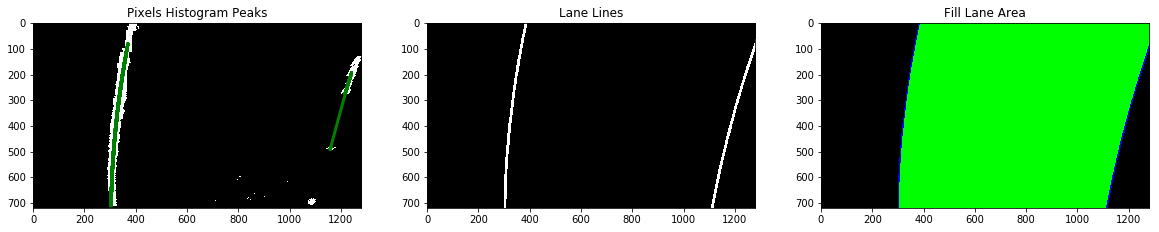

In [11]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty = get_pixels_histogram(warped, horizontal_offset=horizontal_offset)

left_fit, left_coeffs = fit_2nd_order_poly(lefty, leftx, return_coeffs=True)
right_fit, right_coeffs = fit_2nd_order_poly(righty, rightx, return_coeffs=True)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Pixels Histogram Peaks')
plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)

plt.subplot(1,3,2)
plt.title('Lane Lines')
plt.imshow(polyfit_drawn, cmap="gray")

trace = colour_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]

plt.subplot(1,3,3)
plt.title('Fill Lane Area')
plt.imshow(trace)

# Measuring Curvature

I've calculated the radius of curvature based on pixel values, so the radius I am reporting is in pixel space, which is not the same as real world space. 

So I actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that I am projecting in my warped image. 

Here I am projecting a section of lane. 
The lane is about 30 meters long and 3.7 meters wide. 

I derive a conversion from pixel space to world space in my own images.
For my images, I use a lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

Here I repeat the calculation of radius of curvature after correcting for scale in x and y:

## Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

## Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

## Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

## Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')



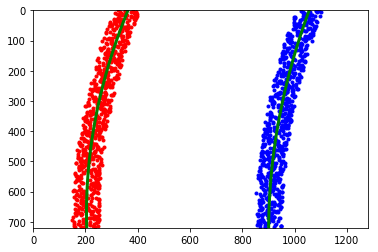

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Generate data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [13]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)


1421.47736581 1712.48424058


In [14]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now my radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


466.084845336 m 562.448526251 m


Left lane curve radius:  3613.45833376 pixels
Right lane curve radius:  4476.64740357 pixels
Left lane curve radius:  466.234104427 meters
Right lane curve radius:  562.688820112 meters


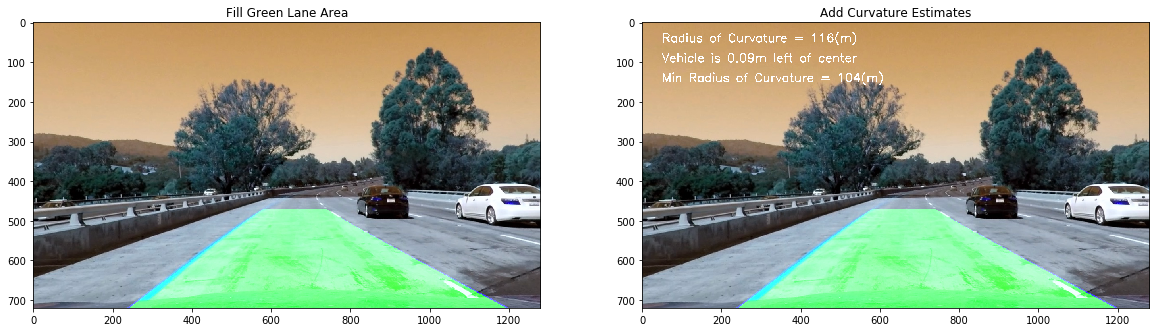

In [15]:
# Determine curvature of the lane
import numpy as np
import matplotlib.pyplot as plt
# Generate data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image


def center(y, left_poly, right_poly):
    mycenter = (1.5 * evaluate_poly(y, left_poly)
              - evaluate_poly(y, right_poly)) / 2
    return mycenter

y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
mycenter = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)


# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now my radius of curvature is in meters
#print(left_curverad, 'm', right_curverad, 'm')  
print("Left lane curve radius: ", left_curverad, "meters")
print("Right lane curve radius: ", right_curverad, "meters")
 

# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to color
combined_img = cv2.add(lane_lines, image)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Fill Green Lane Area')
plt.imshow(combined_img)


add_figures_to_image3(combined_img, curvature=curvature, 
                     vehicle_position=mycenter, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.subplot(1,2,2)
plt.title('Add Curvature Estimates')
plt.imshow(combined_img)

### Pipeline (single images)

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Answer:

First, I measure from where the lane lines are and then estimated how much the road is curving and where the vehicle is located with respect to the center of the lane. 

I calculate the radius of curvature and then the offset position of the vehicle with respect to the car center camera.
I convert the distance from pixels to meters and fit a 2nd order polynomial.


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Answer:

I warped the fit from the rectified image back onto the original image and plotted to identify the lane boundaries. I plot out the image with lanes, curvature, and position from center.

Here is an example of my result on a test image:

![alt text][image6]

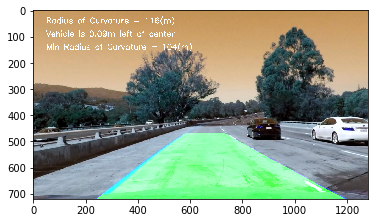

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from supportfunct import *


def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32(
        [[120, 720],
         [550, 470],
         [700, 470],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))
    color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    combined = apply_thresholds(image)

################
    have_fit = False
    curvature_checked = False
    
    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)
    
    while have_fit == False:
        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
 
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
 
        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_2nd_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coeffs = fit_2nd_order_poly(righty, rightx, return_coeffs=True)


    # Determine curvature of the lane
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
        
    mycenter = center(719, left_coeffs, right_coeffs)
        

    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)

    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]

    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)


    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image2(combined_img, curvature=curvature, 
                         vehicle_position=mycenter, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████▉| 1260/1261 [14:59<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 15min


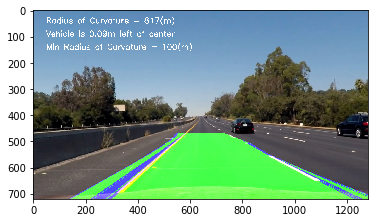

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?
### Pipeline (single images)

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video_output.mp4 "Video"


Answer:

Some of the problems I encountered in identifying the lane lines had to do with the fact that certain parts of the video contain frames when the car goes around curves.  Another part of the video had shadows which created poor lighting and made the lane lines more difficult to detect because the gradients were reduced.

Another challenge was finding and tracking the yellow lane lines on the left.  I experimented with different color spaces that worked better for yellow lines.  In order to make the pipeline more robust, I plan to go back and explore an ensemble approach where I combine the use of different color spaces to detect different color lines in different lighting-challenged conditions.  I think an ensemble approach would let me detect lines in situations where the lines are masked out by shadows or discoloration.


I created an image processing pipeline that processed project video and identified lanes, calculated the radius of curvature of the lane and vehicle position within the lane. Here is the link to the video:  


In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


HTML("""
<video width="960" height="540" controls>
  <source src="project_video_output.mp4">
</video>
""".format(output))